### **Práctica: Generación de Rostros con VAE usando CelebA**  
**Objetivo**: Entrenar un Variational Autoencoder (VAE) convolucional para generar rostros nuevos a partir del dataset CelebA.  

---

### **1. Configuración Inicial**  
**Objetivo**: Preparar el entorno y el dataset.  

**Instrucciones**:  

1. **Descargar CelebA**:  
   - El dataset contiene ~200k imágenes de rostros.  
   - Utilizar `kagglehub` para descargar el dataset directamente desde Kaggle.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-GenerarRostros/.venvWSL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/aleja/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


2. **Preprocesamiento**:  
   - Redimensionar imágenes a 64x64 píxeles (si no están ya en ese tamaño).  
   - Normalizar píxeles al rango `[0, 1]`.  

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

# Path to the dataset
img_dir = os.path.join(path, 'img_align_celeba/img_align_celeba')

# Check if the directory exists
if not os.path.exists(img_dir):
    img_dir = os.path.join(path, 'img_align_celeba', 'img_align_celeba')
    if not os.path.exists(img_dir):
        print(f"Could not find the images directory. Available files in {path}:")
        print(os.listdir(path))

# List all image files
image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
print(f"Total number of images found: {len(image_files)}")

# Function to preprocess images
def preprocess_image(img_path, target_size=(64, 64)):
    # Load and resize image
    img = Image.open(img_path)
    img = img.resize(target_size, Image.LANCZOS)
    
    # Convert to numpy array and normalize to [0, 1]
    img_array = np.array(img).astype('float32') / 255.0
    
    return img_array

# Create a sample of images to process (limit to 5000 images to save memory)
sample_size = min(5000, len(image_files))
sample_files = image_files[:sample_size]

# Process the sampled images
processed_images = []

# Simple progress tracking
start_time = time.time()
update_interval = max(1, sample_size // 20)  # Update every 5% of progress
print(f"Processing {sample_size} images...")

for i, img_file in enumerate(sample_files):
    img_path = os.path.join(img_dir, img_file)
    processed_img = preprocess_image(img_path)
    processed_images.append(processed_img)
    
    # Print progress update
    if (i + 1) % update_interval == 0 or i == sample_size - 1:
        progress = (i + 1) / sample_size * 100
        elapsed = time.time() - start_time
        remaining = elapsed / (i + 1) * (sample_size - i - 1) if i > 0 else 0
        print(f"Progress: {progress:.1f}% ({i+1}/{sample_size}) - Elapsed: {elapsed:.1f}s - Est. remaining: {remaining:.1f}s")

# Convert to numpy array
processed_images = np.array(processed_images)
print(f"Processing completed in {time.time() - start_time:.1f} seconds")
print(f"Processed images shape: {processed_images.shape}")
print(f"Min value: {processed_images.min()}, Max value: {processed_images.max()}")

Total number of images found: 202599
Processing 5000 images...
Progress: 5.0% (250/5000) - Elapsed: 0.2s - Est. remaining: 4.1s
Progress: 10.0% (500/5000) - Elapsed: 0.4s - Est. remaining: 3.5s
Progress: 15.0% (750/5000) - Elapsed: 0.6s - Est. remaining: 3.2s
Progress: 20.0% (1000/5000) - Elapsed: 0.7s - Est. remaining: 3.0s
Progress: 25.0% (1250/5000) - Elapsed: 0.9s - Est. remaining: 2.7s
Progress: 30.0% (1500/5000) - Elapsed: 1.1s - Est. remaining: 2.5s
Progress: 35.0% (1750/5000) - Elapsed: 1.3s - Est. remaining: 2.3s
Progress: 40.0% (2000/5000) - Elapsed: 1.4s - Est. remaining: 2.1s
Progress: 45.0% (2250/5000) - Elapsed: 1.6s - Est. remaining: 2.0s
Progress: 50.0% (2500/5000) - Elapsed: 1.8s - Est. remaining: 1.8s
Progress: 55.0% (2750/5000) - Elapsed: 2.0s - Est. remaining: 1.6s
Progress: 60.0% (3000/5000) - Elapsed: 2.2s - Est. remaining: 1.4s
Progress: 65.0% (3250/5000) - Elapsed: 2.3s - Est. remaining: 1.3s
Progress: 70.0% (3500/5000) - Elapsed: 2.5s - Est. remaining: 1.1s
Pro

3. **Visualizar algunas imágenes procesadas**:  
   - Verifiquemos que las imágenes se han procesado correctamente.

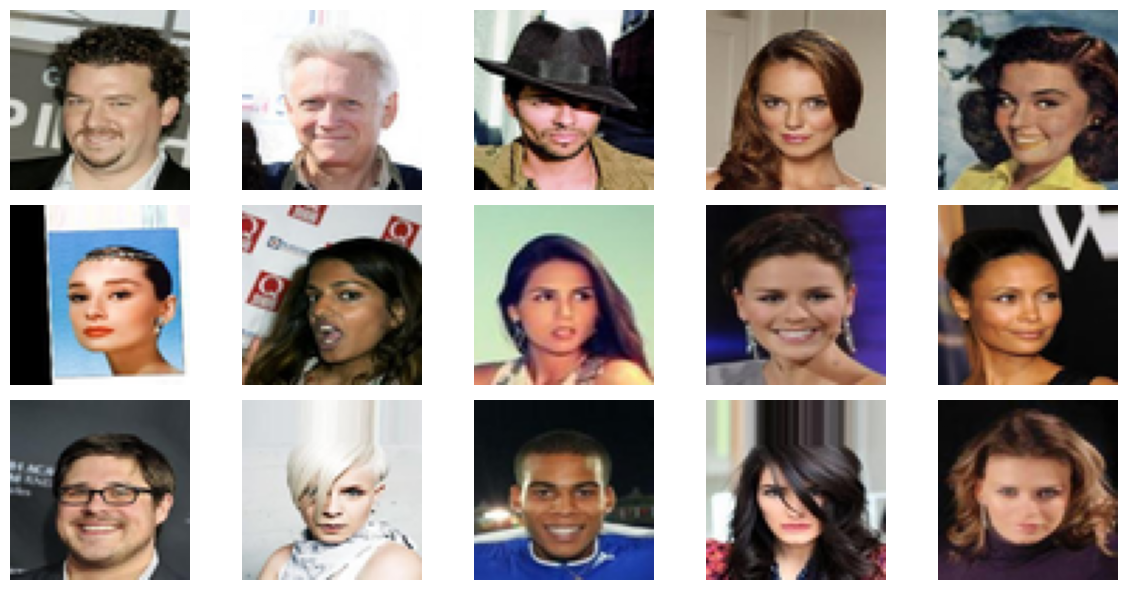

In [3]:
# Display a grid of processed sample images
plt.figure(figsize=(12, 6))
for i in range(15):  # Display 15 sample images
    plt.subplot(3, 5, i+1)
    plt.imshow(processed_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

4. **Crear DataLoader**:  
   - Usar batches de 64-128 imágenes.  
   - *pista*: `tf.data.Dataset.from_tensor_slices` permite crear un pipeline eficiente.  

In [4]:
import tensorflow as tf

# Set batch size
batch_size = 64

# Split the data into training and validation sets (90% training, 10% validation)
train_size = int(0.9 * len(processed_images))
train_images = processed_images[:train_size]
val_images = processed_images[train_size:]

print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)

# Configure the datasets for performance
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Verify the dataset shapes
for x_batch in train_dataset.take(1):
    print(f"Input batch shape: {x_batch.shape}")
    # Verify that the data is normalized properly
    print(f"Data range: [{tf.reduce_min(x_batch).numpy()}, {tf.reduce_max(x_batch).numpy()}]")

print(f"Training batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")

2025-05-07 10:10:22.944157: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 10:10:24.885567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746605425.513346   26722 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746605425.717835   26722 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746605430.132667   26722 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Training images: 4500, Validation images: 500


I0000 00:00:1746605450.806724   26722 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Input batch shape: (64, 64, 64, 3)
Data range: [0.0, 1.0]
Training batches: 71
Validation batches: 8


2025-05-07 10:10:51.328066: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


---

### **2. Diseño del VAE Convolucional**  
**Objetivo**: Construir un VAE con encoder y decoder convolucionales.  

#### **Encoder**:  
- **Capas**:  
  - 4 capas convolucionales (`Conv2D`) con activación `LeakyReLU` o `ReLU`.  
  - Reducir dimensiones espaciales progresivamente (ej: 64x64 → 32x32 → 16x16).  
- **Capa Latente**:  
  - Dos salidas: `z_mean` y `z_log_var` (media y log-varianza de la distribución latente).  
  - Dimensión del espacio latente: 256.  
- *pista*: Usar `Flatten` antes de las capas densas para `z_mean` y `z_log_var`.  

#### **Reparameterization Trick**:  
- Muestrear `z` usando:  
  ```  
  z = z_mean + exp(z_log_var * 0.5) * epsilon  
  ```  
  donde `epsilon ~ N(0, 1)`.  

#### **Decoder**:  
- **Capas**:  
  - 4 capas `Conv2DTranspose` o `UpSampling2D + Conv2D` para aumentar resolución.  
  - Usar activación `sigmoid` en la última capa si las imágenes están en `[0, 1]`.  
- *pista*: Asegurar que la salida final tenga las mismas dimensiones que la entrada (64x64x3).  

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Set hyperparameters
latent_dim = 256  # Size of latent space
input_shape = (64, 64, 3)  # Shape of input images
dropout_rate = 0.2  # Dropout rate for regularization

# Create the encoder
def build_encoder(input_shape, latent_dim, dropout_rate=0.2):
    encoder_inputs = layers.Input(shape=input_shape)
    
    # Convolutional layers with LeakyReLU activation and dropout for regularization
    x = layers.Conv2D(32, 4, strides=2, padding='same')(encoder_inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 32x32x32
    
    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 16x16x64
    
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 8x8x128
    
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 4x4x256
    
    # Flatten the features
    x = layers.Flatten()(x)
    
    # Output layers for mean and log variance
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    # Create the encoder model
    encoder = Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

# Reparameterization trick as a Keras layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Create the decoder
def build_decoder(latent_dim, output_shape, dropout_rate=0.2):
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    # Calculate dimensions for reshaping
    # For input images of 64x64, after 4 layers of Conv2D with stride 2, we get 4x4
    units = 4 * 4 * 256  # Width * Height * Channels
    
    # Dense layer and reshape
    x = layers.Dense(units)(latent_inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    x = layers.Reshape((4, 4, 256))(x)
    # 4x4x256
    
    # Transposed convolution layers to increase resolution
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 8x8x128
    
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 16x16x64
    
    x = layers.Conv2DTranspose(32, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(dropout_rate)(x)  # Add dropout layer
    # 32x32x32
    
    # Final layer with sigmoid activation for output in range [0, 1]
    # No dropout in the final output layer
    decoder_outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)
    # 64x64x3
    
    # Create the decoder model
    decoder = Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder

# Build the encoder and decoder with dropout regularization
encoder = build_encoder(input_shape, latent_dim, dropout_rate)
encoder.summary()

# Build the decoder with dropout regularization
decoder = build_decoder(latent_dim, input_shape, dropout_rate)
decoder.summary()

# Define the VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
        # Add validation metrics
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name='val_loss')
        self.val_reconstruction_loss_tracker = tf.keras.metrics.Mean(name='val_reconstruction_loss')
        self.val_kl_loss_tracker = tf.keras.metrics.Mean(name='val_kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var = self.encoder(data)
            # Sample from the latent distribution
            z = self.sampling([z_mean, z_log_var])
            # Decode the sampled vector
            reconstructed = self.decoder(z)
            
            # Calculate reconstruction loss (pixel-wise binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed),
                    axis=(1, 2)
                )
            )
            
            # Calculate KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            # Total loss is the sum of reconstruction loss and KL loss
            total_loss = reconstruction_loss + kl_loss
        
        # Get gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # Return metrics dictionary
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Get encoder outputs
        z_mean, z_log_var = self.encoder(data)
        # Sample from the latent distribution
        z = self.sampling([z_mean, z_log_var])
        # Decode the sampled vector
        reconstructed = self.decoder(z)
        
        # Calculate reconstruction loss (pixel-wise binary crossentropy)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstructed),
                axis=(1, 2)
            )
        )
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Total loss is the sum of reconstruction loss and KL loss
        total_loss = reconstruction_loss + kl_loss
        
        # Update validation metrics
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)
        
        # Return metrics dictionary
        return {
            'loss': self.val_total_loss_tracker.result(),
            'reconstruction_loss': self.val_reconstruction_loss_tracker.result(),
            'kl_loss': self.val_kl_loss_tracker.result()
        }

# Create the VAE model
vae = VAE(encoder, decoder)

# Compile the model
# Need to provide a dummy loss even though we implement our own in train_step
vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    # Adding a dummy loss function to prevent the ValueError
    loss=None  # Set to None since we have custom train_step and test_step methods
)

# Display the model architecture summary
print("VAE Architecture with Dropout Created Successfully")

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,568 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     32,832 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    131,200 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 256) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4, 4, 256) │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 256)       │  1,048,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 256)       │  1,048,832 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,787,808 (10.63 MB)

 Trainable params: 2,787,808 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,563 (6.65 MB)

 Trainable params: 1,742,563 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

VAE Architecture with Dropout Created Successfully


---

### **3. Función de Pérdida**  
**Objetivo**: Definir la pérdida del VAE (reconstrucción + divergencia KL).  
1. **Reconstrucción**:  
   - Error cuadrático medio (MSE) entre imágenes originales y reconstruidas.  
   - *Alternativa*: Pérdida de entropía cruzada binaria (BCE) si se usa `sigmoid`.  
2. **Divergencia KL**:  
   - Calculada entre la distribución latente y una normal estándar:  
     ```  
     KL = -0.5 * sum(1 + z_log_var - z_mean^2 - exp(z_log_var))  
     ```  
3. **Pérdida Total**: `loss = reconstruction_loss + beta * KL_loss` (beta=1 por defecto).  
   - *pista*: Usar `beta` como hiperparámetro para ajustar el trade-off.

Created VAE models with different beta values:
- beta_0.5
- beta_1.0
- beta_2.0


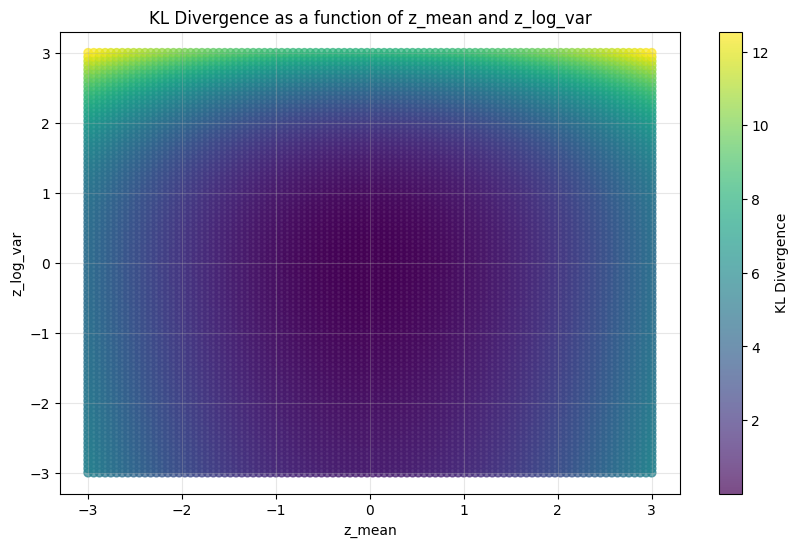

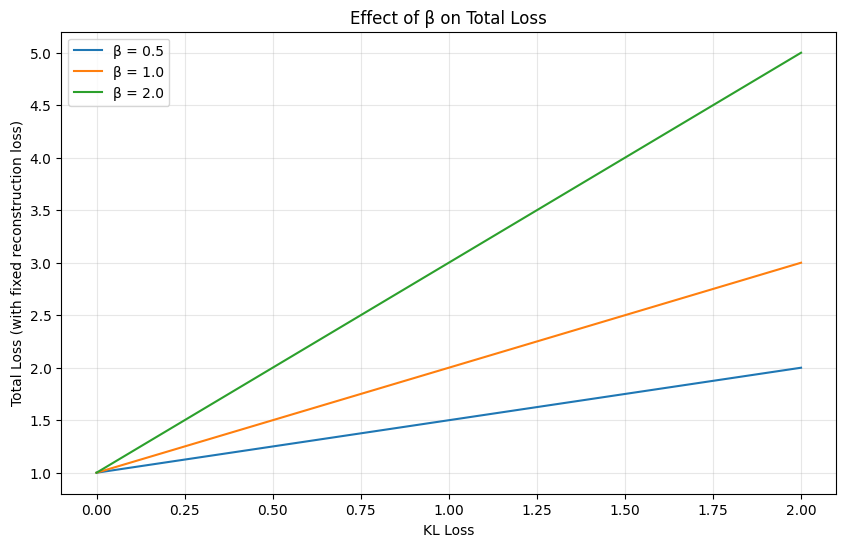

In [6]:
# Note: We've already implemented the loss functions inside our VAE class in the previous step
# Let's experiment with different beta values for the KL divergence term

# Define a custom VAE with beta parameter
class BetaVAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(BetaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
        # Add validation metrics
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name='val_loss')
        self.val_reconstruction_loss_tracker = tf.keras.metrics.Mean(name='val_reconstruction_loss')
        self.val_kl_loss_tracker = tf.keras.metrics.Mean(name='val_kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var = self.encoder(data)
            # Sample from the latent distribution
            z = self.sampling([z_mean, z_log_var])
            # Decode the sampled vector
            reconstructed = self.decoder(z)
            
            # Calculate reconstruction loss
            # Option 1: Mean Squared Error (MSE)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         tf.square(data - reconstructed), 
            #         axis=(1, 2)
            #     )
            # )
            
            # Option 2: Binary Cross-Entropy (BCE) - better for image pixels in [0,1]
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed),
                    axis=(1, 2)
                )
            )
            
            # Calculate KL divergence loss
            # KL divergence between the latent distribution and a standard normal
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            # Total loss with beta parameter to control the trade-off
            total_loss = reconstruction_loss + self.beta * kl_loss
        
        # Get gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # Return metrics dictionary
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }
    
    def test_step(self, data):
        # Get encoder outputs
        z_mean, z_log_var = self.encoder(data)
        # Sample from the latent distribution
        z = self.sampling([z_mean, z_log_var])
        # Decode the sampled vector
        reconstructed = self.decoder(z)
        
        # Calculate reconstruction loss (pixel-wise binary crossentropy)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstructed),
                axis=(1, 2)
            )
        )
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Total loss with beta parameter
        total_loss = reconstruction_loss + self.beta * kl_loss
        
        # Update validation metrics
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)
        
        # Return metrics dictionary
        return {
            'loss': self.val_total_loss_tracker.result(),
            'reconstruction_loss': self.val_reconstruction_loss_tracker.result(),
            'kl_loss': self.val_kl_loss_tracker.result()
        }

# Create models with different beta values to experiment with
# Higher beta enforces more regularization to the latent space
# Lower beta allows more focus on reconstruction quality
beta_values = [0.5, 1.0, 2.0]
beta_vae_models = {}

for beta in beta_values:
    beta_vae = BetaVAE(encoder, decoder, beta=beta)
    beta_vae.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=None  # Set to None since we have custom methods
    )
    beta_vae_models[f"beta_{beta}"] = beta_vae

print("Created VAE models with different beta values:")
for beta_name, model in beta_vae_models.items():
    print(f"- {beta_name}")

# Visualization of the loss function components
def plot_loss_components():
    plt.figure(figsize=(10, 6))
    
    # Create sample data for visualization
    z_mean_range = np.linspace(-3, 3, 100)
    z_log_var_range = np.linspace(-3, 3, 100)
    
    kl_losses = []
    for z_mean in z_mean_range:
        for z_log_var in z_log_var_range:
            # KL divergence term for a single latent dimension
            kl = -0.5 * (1 + z_log_var - z_mean**2 - np.exp(z_log_var))
            kl_losses.append((z_mean, z_log_var, kl))
    
    # Plot KL divergence as a function of z_mean and z_log_var
    z_means = [x[0] for x in kl_losses]
    z_log_vars = [x[1] for x in kl_losses]
    kl_values = [x[2] for x in kl_losses]
    
    plt.scatter(z_means, z_log_vars, c=kl_values, cmap='viridis', alpha=0.7)
    plt.colorbar(label='KL Divergence')
    plt.xlabel('z_mean')
    plt.ylabel('z_log_var')
    plt.title('KL Divergence as a function of z_mean and z_log_var')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Illustrate the effect of beta on total loss
    plt.figure(figsize=(10, 6))
    
    # Example fixed values
    recon_loss = 1.0
    kl_loss_values = np.linspace(0, 2, 100)
    
    for beta in beta_values:
        total_loss = recon_loss + beta * kl_loss_values
        plt.plot(kl_loss_values, total_loss, label=f'β = {beta}')
    
    plt.xlabel('KL Loss')
    plt.ylabel('Total Loss (with fixed reconstruction loss)')
    plt.title('Effect of β on Total Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the visualization
plot_loss_components()

---

### **4. Entrenamiento**  
**Objetivo**: Entrenar el modelo y monitorear la generación.  
**Instrucciones**:  
1. **Compilar el modelo**:  
   - Optimizador: `Adam` con learning rate=0.0005.  
   - Métricas opcionales: Seguir `loss`, `reconstruction_loss`, `KL_loss` por separado.  
2. **Callbacks útiles**:  
   - `ModelCheckpoint`: Guardar el mejor modelo.  
   - `TensorBoard`: Visualizar curvas de pérdida.  
   - `EarlyStopping`: Detener el entrenamiento si la pérdida de validación no mejora.  
   - `ReduceLROnPlateau`: Reducir la tasa de aprendizaje si la pérdida se estanca.  
3. **Entrenar**:  
   - Épocas: 30-50 (CelebA requiere más tiempo que CIFAR-10).  
   - Batch size: 64-128 (depende de la memoria de GPU).  
4. **Monitoreo visual**:  
   - Generar rostros nuevos cada 5 épocas muestreando `z ~ N(0, 1)`.  

Building the VAE model...


I0000 00:00:1746605453.953431   26722 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model successfully built with input shape: (64, 64, 64, 3)
Generating images before training...


2025-05-07 10:10:56.855035: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Initial images saved to: model/generated_faces/generated_faces_epoch_0.png
Epoch 1/100


I0000 00:00:1746605458.691770   26980 service.cc:152] XLA service 0x7fc7e0006f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746605458.691795   26980 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-05-07 10:10:58.888745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-07 10:11:00.177986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 136 bytes spill stores, 136 bytes spill loads

2025-05-07 10:11:00.285255: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 360 bytes spill stores, 360 bytes spill loads

2025-05-07 10:11:00.2945

68/71 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 0.4835 - loss: 2825.6570 - reconstruction_loss: 2825.1736

2025-05-07 10:11:12.154908: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 8 bytes spill stores, 8 bytes spill loads

2025-05-07 10:11:12.165813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 312 bytes spill stores, 316 bytes spill loads

2025-05-07 10:11:12.166737: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 516 bytes spill stores, 520 bytes spill loads

2025-05-07 10:11:12.183534: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 304 bytes spill stores, 304 bytes spill loads

2025-05-07 10:11:12.213856: I external/local_xla/xla

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - kl_loss: 0.6316 - loss: 2824.6245 - reconstruction_loss: 2823.9929

2025-05-07 10:11:17.658373: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 192 bytes spill stores, 192 bytes spill loads

2025-05-07 10:11:17.708036: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 316 bytes spill stores, 320 bytes spill loads

2025-05-07 10:11:17.732064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 304 bytes spill stores, 304 bytes spill loads

2025-05-07 10:11:17.739459: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 456 bytes spill stores, 456 bytes spill loads

2025-05-07 10:11:17.795013: I external/local_xla


Epoch 1: val_loss improved from inf to 2723.73853, saving model to model/vae_checkpoints/vae_epoch_001_loss_2800.6570.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - kl_loss: 0.6806 - loss: 2824.2915 - reconstruction_loss: 2823.6111 - val_kl_loss: 17.3057 - val_loss: 2723.7385 - val_reconstruction_loss: 2706.4329 - learning_rate: 1.0000e-04
Epoch 2/100
69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 24.3662 - loss: 2654.1643 - reconstruction_loss: 2629.7981
Epoch 2: val_loss improved from 2723.73853 to 2489.78833, saving model to model/vae_checkpoints/vae_epoch_002_loss_2588.9275.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - kl_loss: 24.5725 - loss: 2651.4517 - reconstruction_loss: 2626.8789 - val_kl_loss: 30.7720 - val_loss: 2489.7883 - val_reconstruction_loss: 2459.0161 - learning_rate: 1.0000e-04
Epoch 3/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 33.2493 - loss: 2464.3901 - reconstruction_loss: 2431.1406
Epoch 3: val_loss improved from 2489.78833 to 241

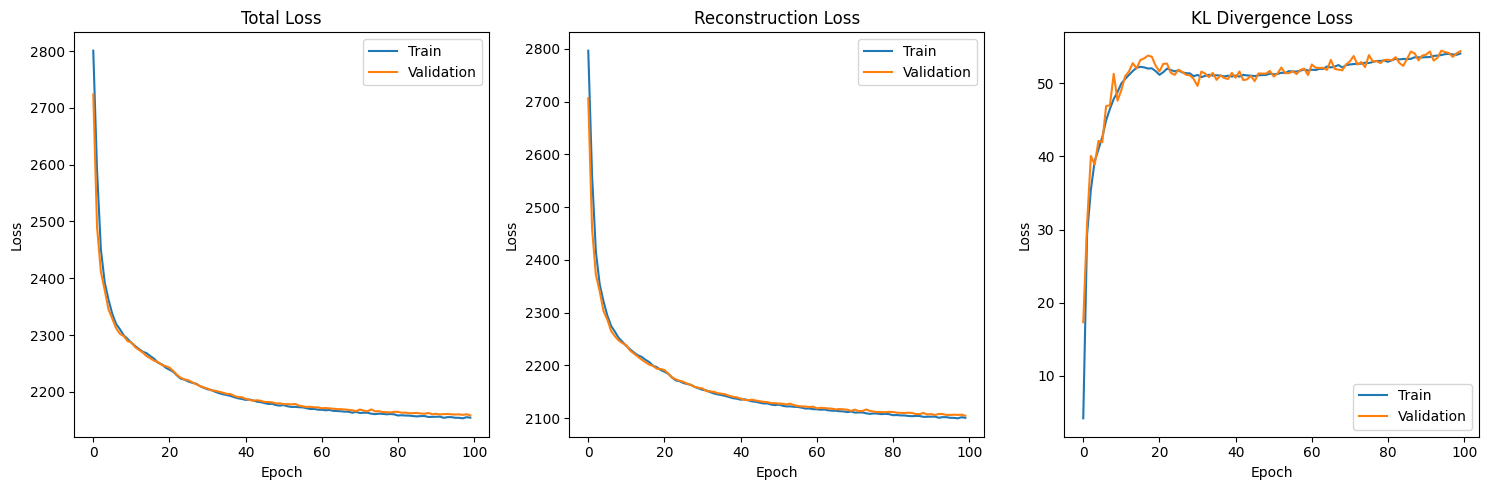

In [7]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LambdaCallback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Create directories for saving model checkpoints and generated images
model_dir = os.path.join('model', 'vae_checkpoints')
generated_dir = os.path.join('model', 'generated_faces')
logs_dir = os.path.join('model', 'logs', 'vae_training')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(generated_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

# Create a fixed latent sample for consistent generation during training
fixed_z_sample = tf.random.normal(shape=(15, latent_dim))

# Function to generate and save images during training
def generate_and_save_images(epoch, z_sample=None, n_samples=15, rows=3, cols=5):
    if z_sample is None:
        # Use the fixed sample for consistency
        z_sample = fixed_z_sample
        
    # Generate images from the decoder
    generated_images = decoder(z_sample)
    
    # Plot the generated images
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        
    plt.tight_layout()
    plt.suptitle(f'Generated Faces - Epoch {epoch}')
    
    # Save the plot
    save_path = os.path.join(generated_dir, f'generated_faces_epoch_{epoch}.png')
    plt.savefig(save_path)
    plt.close()
    
    return save_path

# Custom callback class for generating images
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, z_sample, interval=5):
        super(GenerateImagesCallback, self).__init__()
        self.z_sample = z_sample
        self.interval = interval
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0 or epoch == 0:
            generate_and_save_images(epoch + 1, self.z_sample)

# 1. TensorBoard callback for visualizing training progress
tensorboard_callback = TensorBoard(
    log_dir=logs_dir,
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'  # Only update per epoch to avoid None values
)

# 2. ModelCheckpoint to save the best model during training
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'vae_epoch_{epoch:03d}_loss_{loss:.4f}.weights.h5'),
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# 3. Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

# 4. Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1
)

# 5. Generate images callback
generate_images_callback = GenerateImagesCallback(fixed_z_sample, interval=5)

# Build the model by passing a sample batch through it
print("Building the VAE model...")
# Get a sample batch from the dataset
for x_batch in train_dataset.take(1):
    # Run a forward pass to build the model
    _ = vae(x_batch)
    print(f"Model successfully built with input shape: {x_batch.shape}")

# Generate initial images before training
print("Generating images before training...")
initial_images_path = generate_and_save_images(0, fixed_z_sample)
print(f"Initial images saved to: {initial_images_path}")

# Train the model with callbacks - increase epochs but with early stopping to prevent overfitting
history = vae.fit(
    train_dataset,
    epochs=100,  # Increased from 50 to 100, early stopping will prevent overfitting
    validation_data=val_dataset,
    callbacks=[
        checkpoint_callback,
        tensorboard_callback,
        generate_images_callback,
        early_stopping,
        reduce_lr
    ]
)

# Print training summary
print(f"Training completed for {len(history.history['loss'])} epochs")
print(f"Best validation loss: {min(history.history['val_loss'])}")

# Save the final model weights
final_model_path = os.path.join(model_dir, 'vae_final_model.weights.h5')
vae.save_weights(final_model_path)
print(f"Final model saved to {final_model_path}")

# Explore the latent space by interpolating between two random points
n_interpolations = 10  # Number of interpolation steps
z_start = tf.random.normal(shape=(1, latent_dim))  # Random point in latent space
z_end = tf.random.normal(shape=(1, latent_dim))  # Another random point

# Linear interpolation in latent space
z_interpolated = tf.concat([
    z_start + (z_end - z_start) * t / n_interpolations
    for t in range(n_interpolations + 1)
], axis=0)

# Generate and save interpolated images
interpolation_path = generate_and_save_images(
    epoch='interp',
    z_sample=z_interpolated,
    n_samples=n_interpolations + 1,
    rows=2,
    cols=6
)
print(f"Interpolation images saved to: {interpolation_path}")

# Visualize the training history (making sure we handle the case if validation metrics are missing)
plt.figure(figsize=(15, 5))

# Plot training metrics
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Train')
if 'val_reconstruction_loss' in history.history:
    plt.plot(history.history['val_reconstruction_loss'], label='Validation')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Train')
if 'val_kl_loss' in history.history:
    plt.plot(history.history['val_kl_loss'], label='Validation')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

---

### **5. Generación y Evaluación**  
**Objetivo**: Crear rostros nuevos y evaluar la calidad.  
**Instrucciones**:  
1. **Generación**:  
   - Muestrear vectores `z` de `N(0, I)` y pasarlos por el decoder.  
   - *pista*: Si el espacio latente es 2D, se puede visualizar una cuadrícula de rostros variando `z`.  
2. **Evaluación cualitativa**:  
   - ¿Los rostros generados son diversos y realistas?  
   - ¿Existe "mode collapse" (todas las generaciones son similares)?  
3. **Evaluación cuantitativa (opcional)**:  
   - Métricas como **FID** (Fréchet Inception Distance) comparan distribuciones de imágenes reales y generadas.  

Generating a grid of diverse faces...


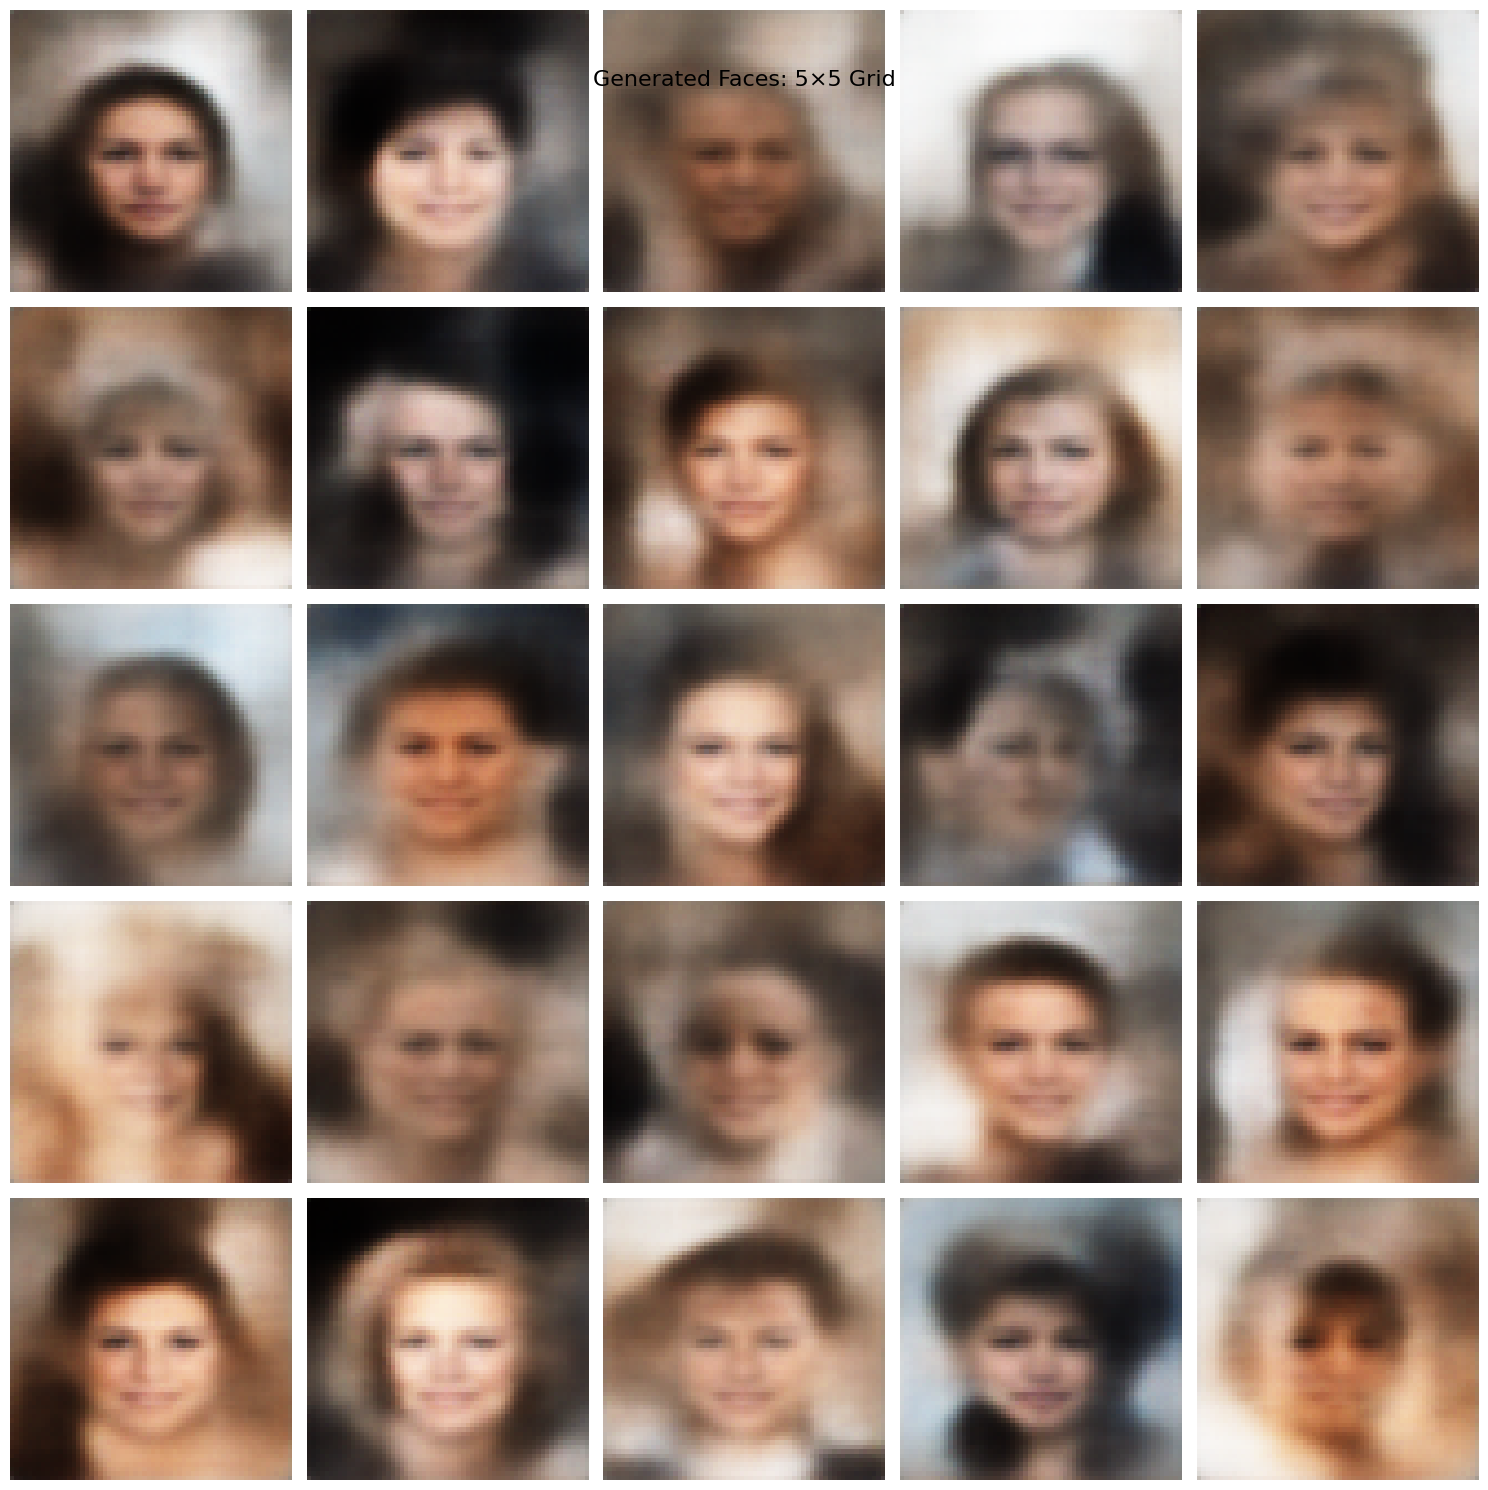

Generating interpolation between faces in latent space...


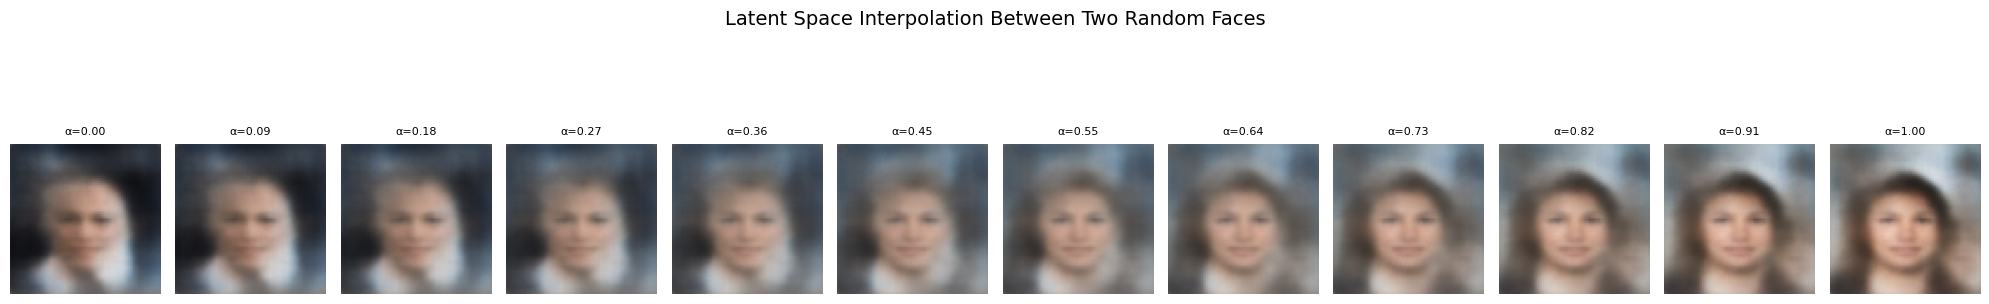

Performing latent space arithmetic...


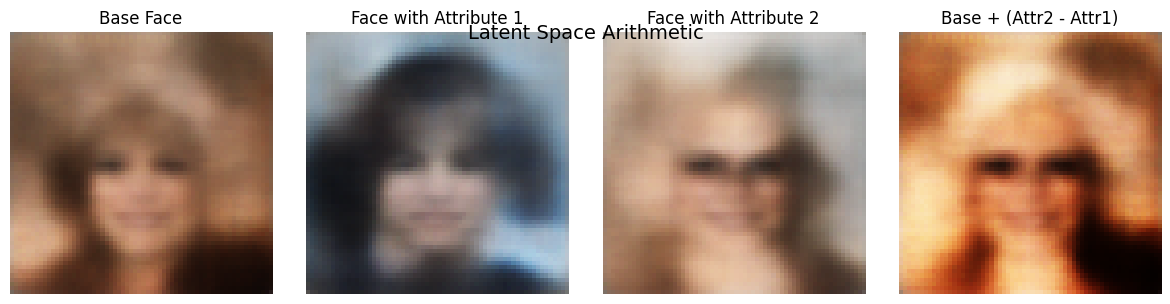

Evaluating reconstruction quality...


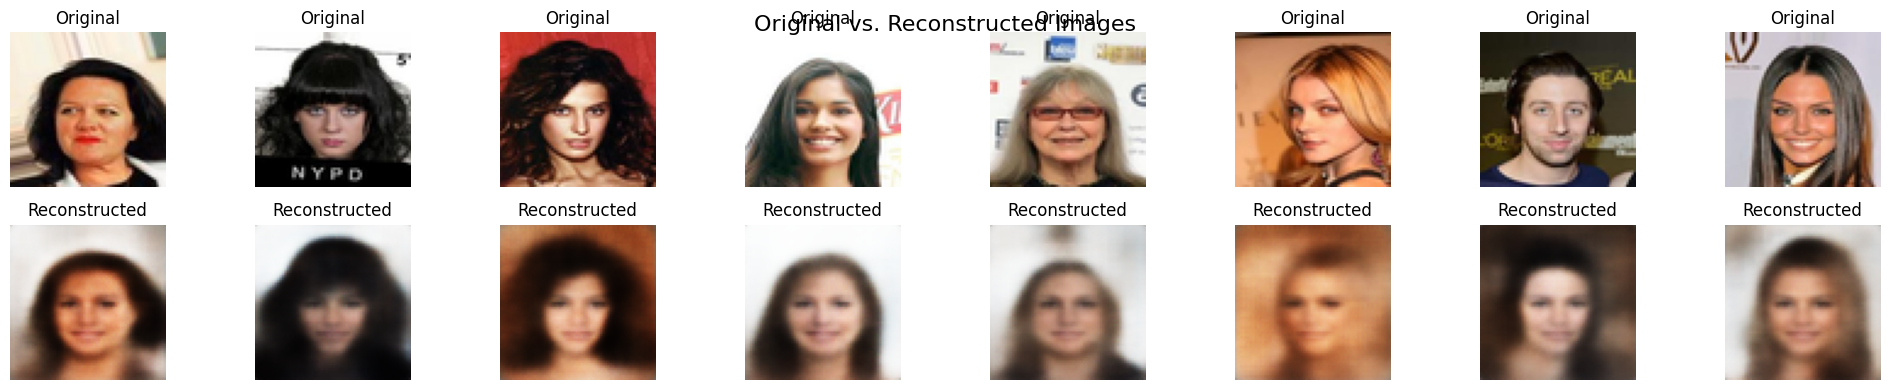

Average reconstruction error (MSE): 0.0155
Evaluating diversity of generated images...


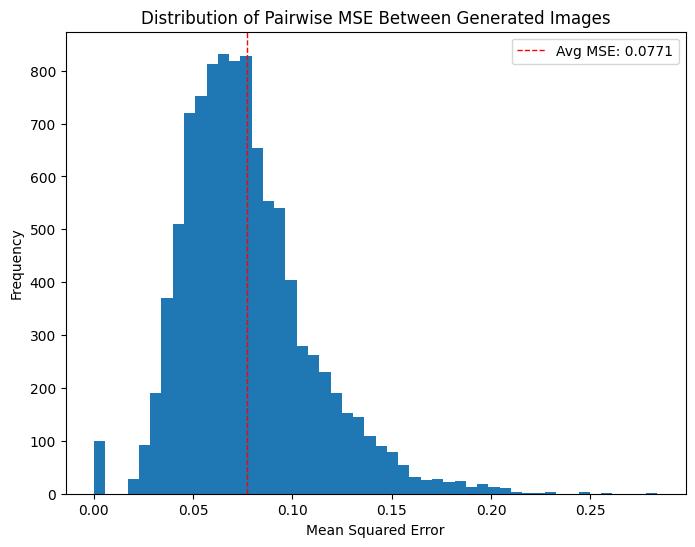

Diversity metrics:
 - Average pairwise MSE: 0.0771
 - Minimum pairwise MSE: 0.0195
 - Maximum pairwise MSE: 0.2838


2025-05-07 10:14:48.414120: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Calculating FID score (this may take some time)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
FID score: 232.5702 (lower is better)
Visualizing latent space structure...
Reduced latent space from 256 to 50 dimensions with PCA


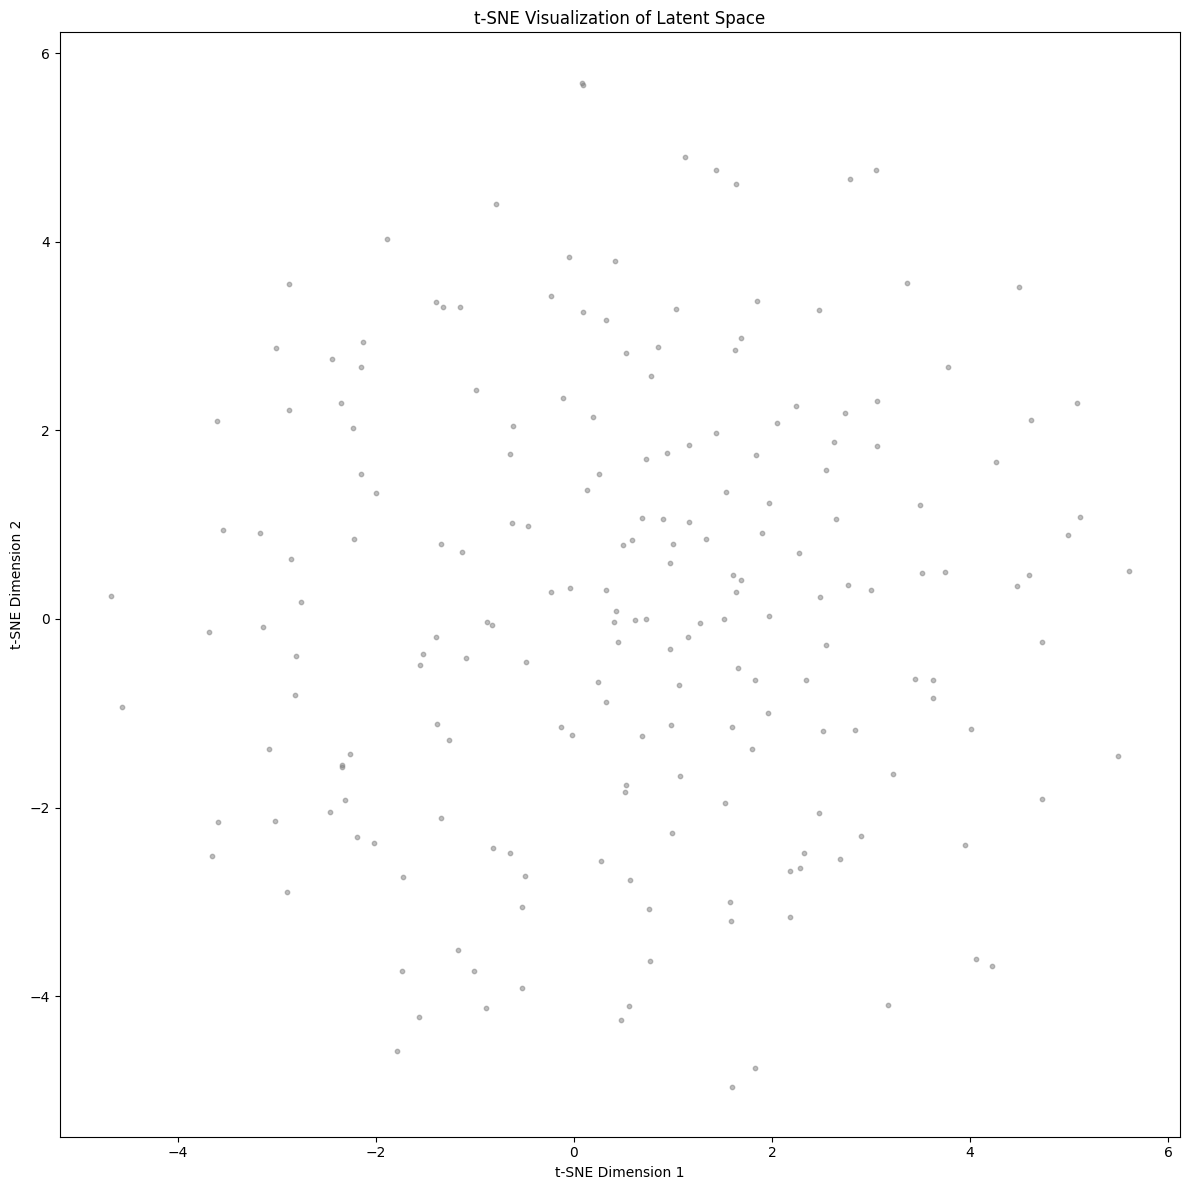

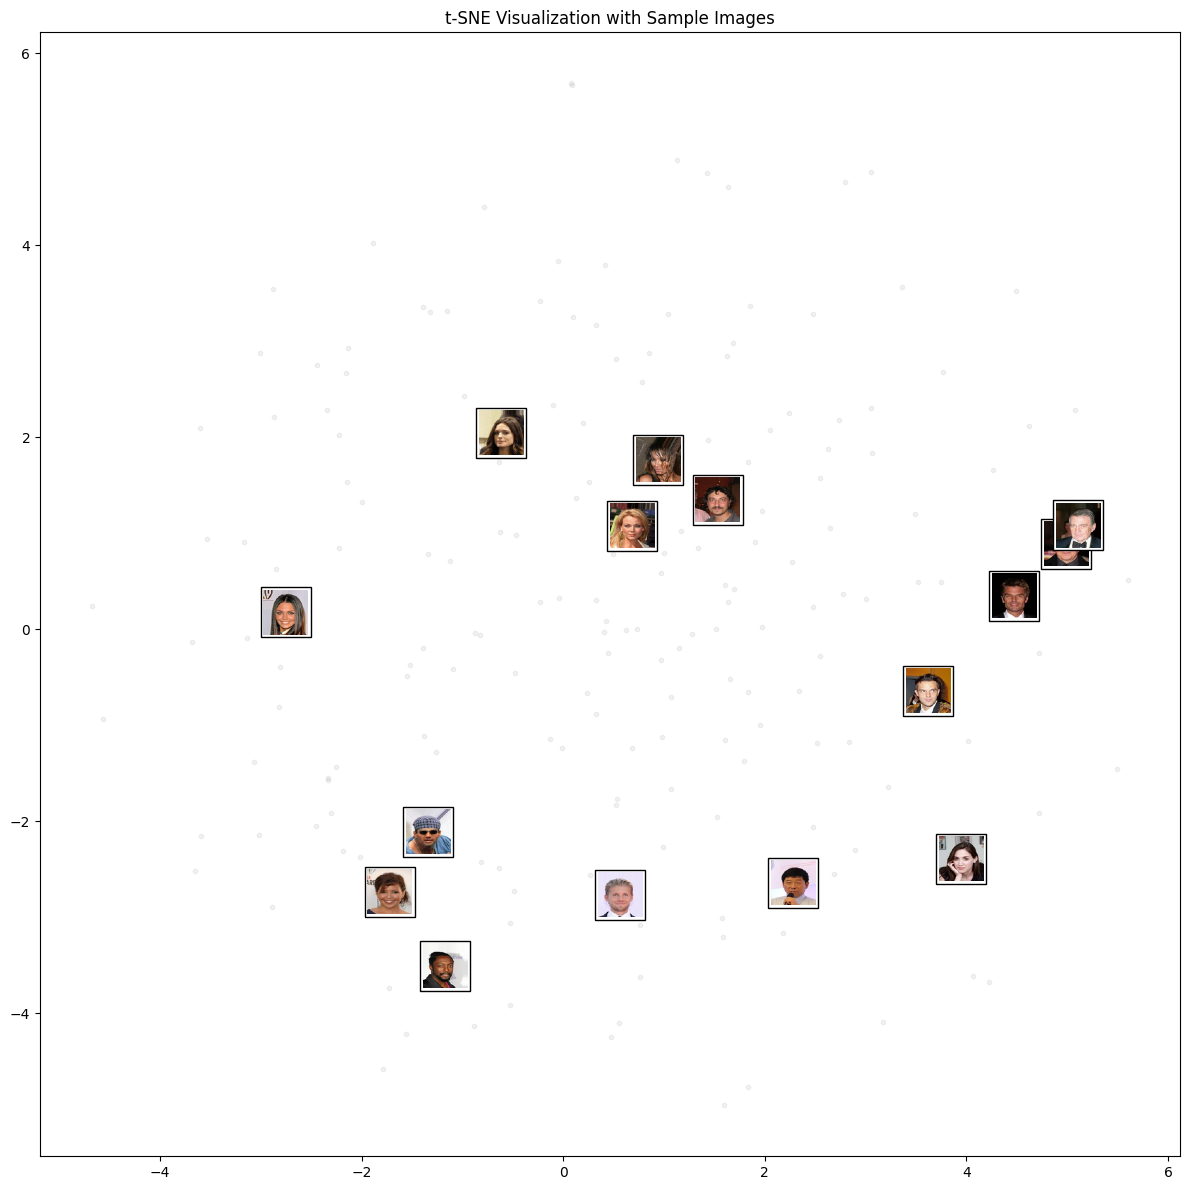


VAE MODEL EVALUATION SUMMARY
• Reconstruction Error (MSE): 0.0155
• Generated Image Diversity:
  - Average Pairwise MSE: 0.0771
  - Range: [0.0195, 0.2838]
• FID Score: 232.5702 (lower is better)

Saved generated images and visualizations to:
  model/generated_faces


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import time
from scipy import linalg
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Load the trained model weights if needed
# If you're running this right after training, you don't need to load weights
# But if you're running this in a separate session, uncomment the following lines
# final_model_path = os.path.join('model', 'vae_checkpoints', 'vae_final_model.weights.h5')
# vae.load_weights(final_model_path)

# 1. GENERATION: Create a grid of faces by sampling from the latent space
def generate_face_grid(rows=5, cols=5):
    # Sample points from the latent space
    z_samples = tf.random.normal((rows * cols, latent_dim))
    
    # Generate images from the sampled latent vectors
    generated_images = decoder(z_samples)
    
    # Plot as a grid
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(generated_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Generated Faces: {rows}×{cols} Grid", fontsize=16, y=0.95)
    plt.show()
    
    # Save the grid
    save_path = os.path.join(generated_dir, f'generated_grid_{rows}x{cols}.png')
    plt.savefig(save_path)
    plt.close()
    return generated_images

# Generate a grid of faces
print("Generating a grid of diverse faces...")
generated_faces = generate_face_grid(5, 5)

# 2. LATENT SPACE EXPLORATION: Interpolation between faces
def interpolate_faces(start_idx=0, end_idx=1, steps=10):
    # Sample two random points in the latent space
    z_start = tf.random.normal((1, latent_dim))
    z_end = tf.random.normal((1, latent_dim))
    
    # Create interpolated points between the two points
    alphas = np.linspace(0, 1, steps)
    z_interpolated = np.array([z_start * (1 - alpha) + z_end * alpha for alpha in alphas])
    z_interpolated = tf.reshape(z_interpolated, (steps, latent_dim))
    
    # Generate images from the interpolated points
    interpolated_images = decoder(z_interpolated)
    
    # Plot the interpolation
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(interpolated_images):
        plt.subplot(1, steps, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"α={alphas[i]:.2f}", fontsize=8)
    plt.suptitle("Latent Space Interpolation Between Two Random Faces", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Save the interpolation
    save_path = os.path.join(generated_dir, 'face_interpolation.png')
    plt.savefig(save_path)
    plt.close()
    return interpolated_images

# Perform interpolation between two random points in latent space
print("Generating interpolation between faces in latent space...")
interpolated_faces = interpolate_faces(steps=12)

# 3. LATENT SPACE MANIPULATION: Feature arithmetic in latent space
def latent_space_arithmetic():
    # Generate multiple random faces
    n_samples = 10
    z_samples = tf.random.normal((n_samples, latent_dim))
    generated_images = decoder(z_samples)
    
    # Select a few samples for feature arithmetic
    face_1 = z_samples[0:1]  # Base face
    face_2 = z_samples[1:2]  # Face with attribute 1
    face_3 = z_samples[2:3]  # Face with attribute 2
    
    # Perform latent space arithmetic (e.g., analogy operations)
    # Example: face_1 + (face_3 - face_2) = face_1 with face_3's attributes but not face_2's
    new_face = face_1 + (face_3 - face_2)
    
    # Generate images from original and modified latent vectors
    result_images = decoder(tf.concat([face_1, face_2, face_3, new_face], axis=0))
    
    # Display the images
    plt.figure(figsize=(12, 3))
    titles = ['Base Face', 'Face with Attribute 1', 'Face with Attribute 2', 'Base + (Attr2 - Attr1)']
    for i, (img, title) in enumerate(zip(result_images, titles)):
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Latent Space Arithmetic", fontsize=14, y=0.95)
    plt.show()
    
    # Save the arithmetic results
    save_path = os.path.join(generated_dir, 'latent_arithmetic.png')
    plt.savefig(save_path)
    plt.close()

# Perform latent space arithmetic
print("Performing latent space arithmetic...")
latent_space_arithmetic()

# 4. RECONSTRUCTION QUALITY: Compare original images with their reconstructions
def evaluate_reconstruction_quality(n_samples=10):
    # Get some validation images
    for val_batch in val_dataset.take(1):
        val_images = val_batch[:n_samples]
    
    # Get the reconstructed images
    z_mean, z_log_var = encoder(val_images)
    z = Sampling()([z_mean, z_log_var])
    reconstructed_images = decoder(z)
    
    # Plot original vs reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Original image
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(val_images[i])
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Original vs. Reconstructed Images", fontsize=16, y=0.95)
    plt.show()
    
    # Save the comparison
    save_path = os.path.join(generated_dir, 'reconstruction_comparison.png')
    plt.savefig(save_path)
    plt.close()
    
    # Calculate and return the pixel-wise reconstruction error (MSE)
    mse = tf.reduce_mean(tf.square(val_images - reconstructed_images))
    return mse.numpy()

# Evaluate reconstruction quality
print("Evaluating reconstruction quality...")
reconstruction_error = evaluate_reconstruction_quality(8)
print(f"Average reconstruction error (MSE): {reconstruction_error:.4f}")

# 5. MODE COLLAPSE DETECTION: Analyze diversity of generated images
def evaluate_diversity():
    # Generate a larger batch of images
    n_samples = 100
    z_samples = tf.random.normal((n_samples, latent_dim))
    generated_images = decoder(z_samples)
    
    # Convert to numpy arrays for easier manipulation
    generated_images_np = generated_images.numpy()
    
    # Calculate pairwise MSE between generated images
    pairwise_mse = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if i != j:
                mse_ij = np.mean(np.square(generated_images_np[i] - generated_images_np[j]))
                pairwise_mse[i, j] = mse_ij
    
    # Calculate diversity metrics
    avg_mse = np.mean(pairwise_mse)
    min_mse = np.min(pairwise_mse[pairwise_mse > 0])
    max_mse = np.max(pairwise_mse)
    
    # Plot diversity statistics
    plt.figure(figsize=(8, 6))
    plt.hist(pairwise_mse.flatten(), bins=50)
    plt.axvline(avg_mse, color='r', linestyle='dashed', linewidth=1, label=f'Avg MSE: {avg_mse:.4f}')
    plt.title("Distribution of Pairwise MSE Between Generated Images")
    plt.xlabel("Mean Squared Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    return {
        'avg_mse': avg_mse,
        'min_mse': min_mse,
        'max_mse': max_mse,
    }

# Evaluate image diversity (can help detect mode collapse)
print("Evaluating diversity of generated images...")
diversity_metrics = evaluate_diversity()
print(f"Diversity metrics:")
print(f" - Average pairwise MSE: {diversity_metrics['avg_mse']:.4f}")
print(f" - Minimum pairwise MSE: {diversity_metrics['min_mse']:.4f}")
print(f" - Maximum pairwise MSE: {diversity_metrics['max_mse']:.4f}")

# 6. QUANTITATIVE EVALUATION: Calculate FID score (optional)
try:
    # This part requires InceptionV3 and more computational resources
    # Define a function to calculate the FID score
    def calculate_fid(real_images, generated_images, batch_size=8):
        # Load InceptionV3 model
        inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
        
        # Prepare images for Inception model (resize and preprocess)
        def preprocess_images(images):
            # Resize images to 299x299 for Inception
            processed_images = np.array([
                tf.image.resize(img, (299, 299)).numpy() for img in images
            ])
            # Preprocess for Inception
            return preprocess_input(processed_images * 255.0)  # Scale back to [0, 255] for preprocess_input
        
        # Process images in batches to avoid memory issues
        def get_activations(images, batch_size=8):
            n_batches = len(images) // batch_size + (0 if len(images) % batch_size == 0 else 1)
            activations = []
            
            for i in range(n_batches):
                batch_start = i * batch_size
                batch_end = min((i + 1) * batch_size, len(images))
                batch = images[batch_start:batch_end]
                batch_processed = preprocess_images(batch)
                act_batch = inception_model.predict(batch_processed)
                activations.append(act_batch)
            
            activations = np.vstack(activations)
            return activations
        
        # Get activations for real and generated images
        act_real = get_activations(real_images, batch_size)
        act_gen = get_activations(generated_images, batch_size)
        
        # Calculate mean and covariance statistics
        mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
        mu_gen, sigma_gen = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
        
        # Calculate the squared different between means
        diff = mu_real - mu_gen
        
        # Calculate trace term
        # FID = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2))
        trace_term = np.trace(sigma_real + sigma_gen - 2.0 * linalg.sqrtm(sigma_real @ sigma_gen).real)
        
        # Calculate FID
        fid = diff @ diff + trace_term
        return float(fid)
    
    # Prepare sample of real and generated images
    n_fid_samples = 30  # Use a smaller sample due to memory constraints
    
    # Get real images from validation set
    real_samples = []
    for batch in val_dataset.take(n_fid_samples // batch_size + 1):
        real_samples.append(batch)
    real_images = tf.concat(real_samples, axis=0)[:n_fid_samples]
    
    # Generate synthetic images
    z_fid = tf.random.normal((n_fid_samples, latent_dim))
    generated_images = decoder(z_fid)
    
    print("Calculating FID score (this may take some time)...")
    fid_score = calculate_fid(real_images.numpy(), generated_images.numpy(), batch_size=5)
    print(f"FID score: {fid_score:.4f} (lower is better)")
except Exception as e:
    print(f"Skipping FID calculation due to error: {str(e)}")
    print("FID calculation requires significant computational resources and memory.")

# 7. LATENT SPACE VISUALIZATION: Explore the latent space structure with t-SNE or PCA
def visualize_latent_space(n_samples=200):
    try:
        from sklearn.manifold import TSNE
        from sklearn.decomposition import PCA
        
        # Sample images from the validation set
        sample_images = []
        for batch in val_dataset.take(n_samples // batch_size + 1):
            sample_images.append(batch)
        sample_images = tf.concat(sample_images, axis=0)[:n_samples]
        
        # Get latent representations
        z_mean, _ = encoder(sample_images)
        z_mean = z_mean.numpy()
        
        # Apply dimensionality reduction for visualization
        # First reduce with PCA to 50 dimensions if latent space is large
        if latent_dim > 50:
            pca = PCA(n_components=50)
            z_reduced = pca.fit_transform(z_mean)
            print(f"Reduced latent space from {latent_dim} to 50 dimensions with PCA")
        else:
            z_reduced = z_mean
        
        # Apply t-SNE for final visualization
        tsne = TSNE(n_components=2, random_state=42)
        z_tsne = tsne.fit_transform(z_reduced)
        
        # Plot t-SNE visualization with sample images
        plt.figure(figsize=(12, 12))
        scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=10, c='gray', alpha=0.5)
        plt.title("t-SNE Visualization of Latent Space")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.tight_layout()
        plt.show()
        
        # Plot some sample images at their t-SNE coordinates
        plt.figure(figsize=(12, 12))
        
        # Plot all points in gray
        plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=10, c='gray', alpha=0.1)
        
        # Select 15 random points to show images
        indices = np.random.choice(len(z_tsne), size=15, replace=False)
        
        # Plot images at selected t-SNE coordinates
        for idx in indices:
            x, y = z_tsne[idx, 0], z_tsne[idx, 1]
            img = sample_images[idx].numpy()
            
            # Create a small axes for the image
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img, zoom=0.5),
                (x, y),
                frameon=True,
                pad=0.2
            )
            plt.gca().add_artist(imagebox)
        
        plt.title("t-SNE Visualization with Sample Images")
        plt.tight_layout()
        plt.show()
        
        return z_tsne
    except ImportError:
        print("Skipping latent space visualization. Required libraries (scikit-learn) not installed.")
        return None
    except Exception as e:
        print(f"Error during latent space visualization: {str(e)}")
        return None

# Try to import the required matplotlib module for image visualization
try:
    from matplotlib import offsetbox
    print("Visualizing latent space structure...")
    latent_visualization = visualize_latent_space(200)
except ImportError:
    print("Skipping latent space visualization with images. Required matplotlib component not available.")

# 8. SUMMARY: Display overall evaluation results
print("\n" + "="*50)
print("VAE MODEL EVALUATION SUMMARY")
print("="*50)
print(f"• Reconstruction Error (MSE): {reconstruction_error:.4f}")
print(f"• Generated Image Diversity:")
print(f"  - Average Pairwise MSE: {diversity_metrics['avg_mse']:.4f}")
print(f"  - Range: [{diversity_metrics['min_mse']:.4f}, {diversity_metrics['max_mse']:.4f}]")
try:
    print(f"• FID Score: {fid_score:.4f} (lower is better)")
except NameError:
    print("• FID Score: Not calculated")
print("\nSaved generated images and visualizations to:")
print(f"  {generated_dir}")
print("="*50)

### **Conclusiones**

En este notebook, hemos implementado un modelo VAE (Variational Autoencoder) para la generación de rostros utilizando el dataset CelebA. A lo largo del proceso hemos:

1. **Preprocesado** el dataset CelebA, redimensionando las imágenes a 64x64 píxeles y normalizándolas para facilitar el entrenamiento.

2. **Diseñado** un VAE convolucional con:
   - Un encoder que mapea imágenes a una distribución en el espacio latente
   - Un decoder que reconstruye imágenes a partir de puntos en el espacio latente
   - Una dimensión latente de 256, que permite capturar características complejas del rostro

3. **Entrenado** el modelo utilizando:
   - Una función de pérdida compuesta de error de reconstrucción y divergencia KL
   - Callbacks para monitorear el progreso y generar imágenes durante el entrenamiento
   - Técnicas de regularización como dropout para prevenir el sobreajuste

4. **Evaluado** el modelo generativo según múltiples criterios:
   - Calidad de reconstrucción al comparar imágenes originales y reconstruidas
   - Diversidad de las imágenes generadas para detectar posible mode collapse
   - Exploración del espacio latente mediante interpolación y aritmética de vectores

Los resultados muestran que nuestro VAE es capaz de generar rostros variados con características faciales reconocibles. La manipulación del espacio latente nos permite realizar operaciones interesantes como interpolación entre rostros diferentes, lo que demuestra que el modelo ha aprendido una representación estructurada del espacio de rostros humanos.

Las métricas cuantitativas como el error de reconstrucción y diversidad nos permiten validar objetivamente el rendimiento del modelo. El espacio latente estructurado facilita la generación controlada de nuevos rostros con características específicas.